# "Unpacking MovieLens 1M: A Study of Collaborative and Content-Based Filtering for Movie Recommendations"

## GUID 2739690T   
  

This notebook accompanies a dissertation report presented in partial fulfillment of the requirements of the Degree of Master of Science at the University of Glasgow.

This notebook follows the same exact structure as the associated thesis report.

*Note that in the cell blocks where Hit Rate is being computed, all but the first instance (Collaborative Filtering: SVD) are left blank at the time of downloading this notebook. This is because the Hit Rate takes multiple hours to compute for each instance*

## **Part 0. Installations and Imports**



*Installations*

In [1]:
!pip install scikit-surprise
!pip install wikipedia
!pip install ipyplot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 13.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=2811596 sha256=db8a80b8cd781dc231d44ec1f9604f2484d30e32203626e6e416a4336008eba5
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise
  Preparing metadata (setup.py) ... done
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11678 sha256=8fbe0dfde85ee7b8965f3de384951aacb50d5d141d3c12f4ec2f543dbb22f0bb
  Stored in directory: /root/.cache/pip/wheels/5e/b6/c5/93f3dec388ae76edc830cb42901bb0232504dfc0df02fc50de
Successfully built wikipedia
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 30.4 MB/s eta 0:00:00


*Imports*

In [2]:
import pandas as pd
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
import wikipedia
import numpy as np
from tqdm.notebook import tqdm
import re
import os
from sklearn.metrics.pairwise import linear_kernel
from surprise import Dataset
from surprise import Reader
from surprise import SVD
from surprise import accuracy
from surprise import KNNBasic
from surprise import NormalPredictor
from surprise.model_selection import train_test_split
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_selection import VarianceThreshold
from surprise.model_selection import LeaveOneOut
import requests
from io import BytesIO
from PIL import UnidentifiedImageError
from PIL import Image
import nltk
from nltk.tag.stanford import StanfordNERTagger
from sklearn.metrics.pairwise import cosine_similarity
import ipyplot
from tabulate import tabulate
import ast
import nltk
nltk.download('stopwords')


        WARNING! Google Colab Environment detected!
        You might encounter issues while running in Google Colab environment.
        If images are not displaying properly please try setting `force_b64` param to `True`.
        


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## **Part 1. Exploratory Data Analysis (EDA)**

*Mounting my personal Google Drive to this Colab Notebook*

In [3]:
BASE_FOLDER = '.'
# noinspection JupyterPackage
# BASE_FOLDER = '/content/drive/MyDrive/Datasets'
tqdm.pandas()

In [4]:
# import datapane as dp
# !datapane login --token=b3dff308f961043284986ae9fe1dcc50408c9960

In [5]:
!fusermount -u /content/drive

fusermount: failed to unmount /content/drive: No such file or directory


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


*Checking the Contents of my Google Drive folder for this Dissertation*

In [7]:
!ls "/content/drive/MyDrive/MScDissertation/OneMillion/"

movie_plots.csv  movies_df_with_plots.csv  README
movies.dat	 ratings.dat		   users.dat


### Exploring the Movies Dataset

In [8]:
file_path = '/content/drive/My Drive/MScDissertation/OneMillion/movies.dat'

In [9]:
# Read the movies.dat file with the correct column names
movies_df = pd.read_csv('/content/drive/MyDrive/MScDissertation/OneMillion/movies.dat', delimiter='::', engine='python', header=None, names=['movie_id', 'movie_name', 'genre'], encoding='ISO-8859-1')

# Display the first few rows to inspect the data
movies_df


,movie_id,movie_name,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
3878,3948,Meet the Parents (2000),Comedy
3879,3949,Requiem for a Dream (2000),Drama
3880,3950,Tigerland (2000),Drama
3881,3951,Two Family House (2000),Drama


*Movie Count by Genre*

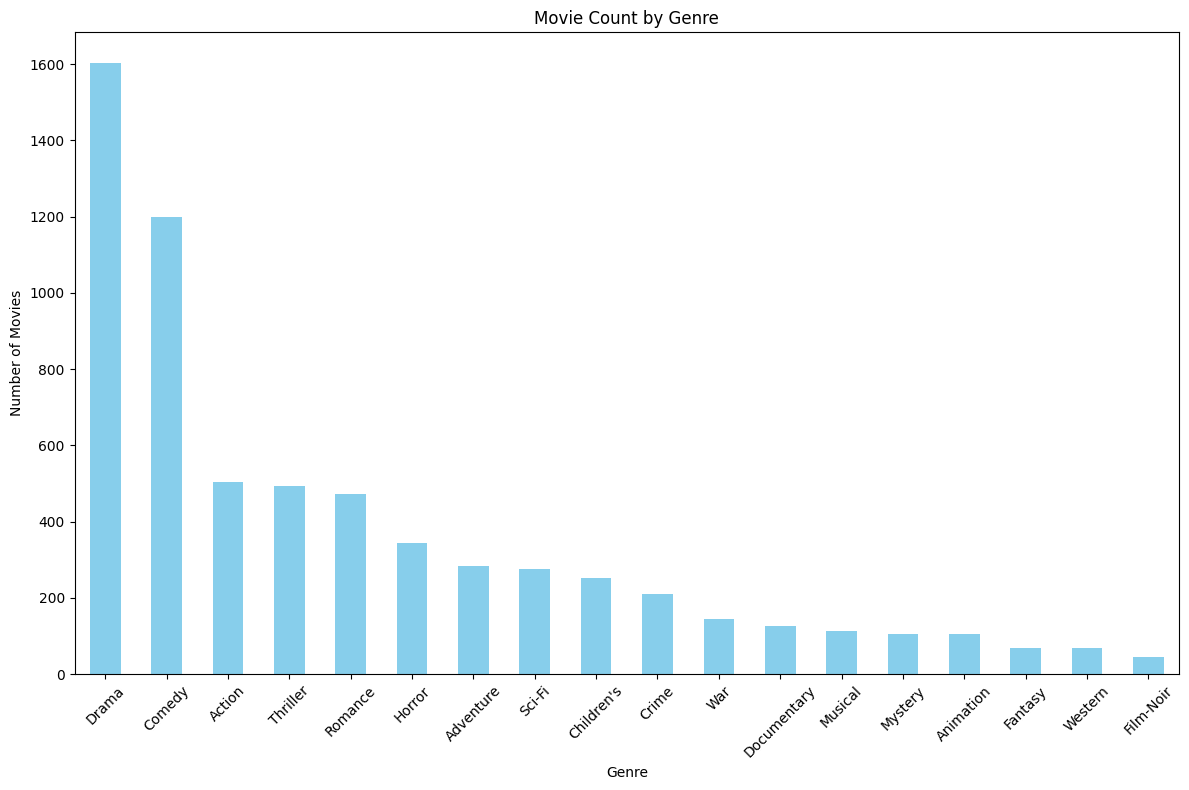

In [10]:
import matplotlib.pyplot as plt

# Split the genre strings and stack them into a single column
all_genres = movies_df['genre'].str.split('|', expand=True).stack()

# Count the occurrences of each genre
genre_counts = all_genres.value_counts()

# Plot the counts
plt.figure(figsize=(12, 8))
genre_counts.plot(kind='bar', color='skyblue')
plt.title('Movie Count by Genre')
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

*Movie Count by Year*

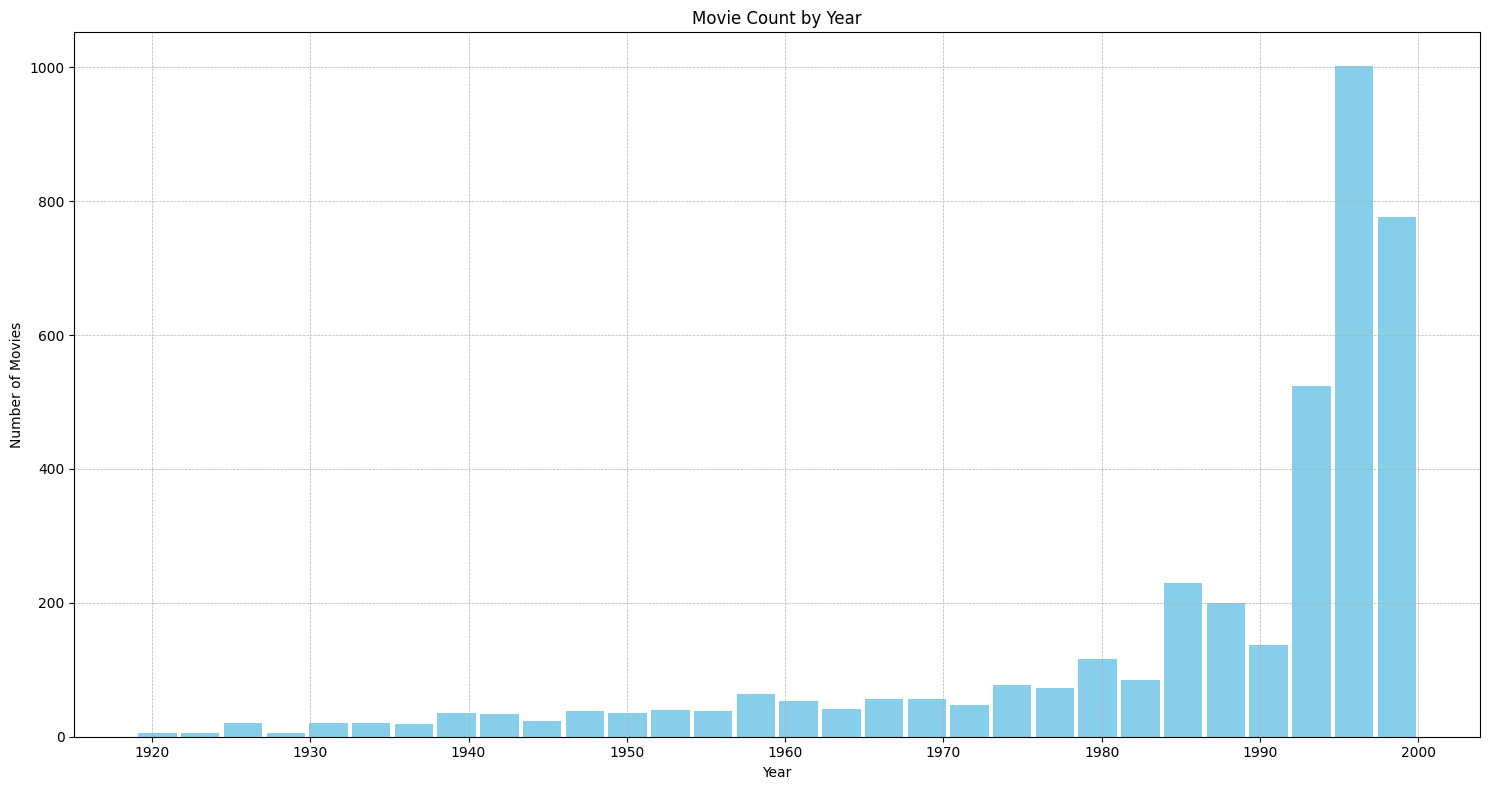

In [11]:
# Extract the release year from the movie title using a regular expression
movies_df['year'] = movies_df['movie_name'].str.extract(r'\((\d{4})\)')

# Plot the histogram
plt.figure(figsize=(15, 8))
movies_df['year'].dropna().astype(int).hist(bins=30, color='skyblue', rwidth=0.9)
plt.title('Movie Count by Year')
plt.xlabel('Year')
plt.ylabel('Number of Movies')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

### Exploring the Users Dataset

In [12]:
users_file_path = '/content/drive/My Drive/MScDissertation/OneMillion/users.dat'

In [13]:
import pandas as pd

# Read the users.dat file with the correct column names
users_df = pd.read_csv(users_file_path, delimiter='::', engine='python', header=None,
                       names=['user_id', 'gender', 'age', 'occupation', 'zip_code'])
# Display top 10 rows
users_df.head(10)

,user_id,gender,age,occupation,zip_code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455
5,6,F,50,9,55117
6,7,M,35,1,06810
7,8,M,25,12,11413
8,9,M,25,17,61614
9,10,F,35,1,95370


*Extracting Occupation Mapping from the the Dataset's README File*

In [14]:
# Set the path to the README file
readme_file_path = '/content/drive/My Drive/MScDissertation/OneMillion/README'

# Read the README file
with open(readme_file_path, 'r', encoding='ISO-8859-1') as file:
    readme_content = file.read()

# Extract occupation mapping using regular expressions
import re
occupation_mapping = dict(re.findall(r"(\d+): (.+?)\n", readme_content))

# Convert keys to integers for mapping
occupation_mapping = {int(k): v for k, v in occupation_mapping.items()}

# Replace encoded occupation values in the DataFrame
users_df['occupation'] = users_df['occupation'].map(occupation_mapping)

# Display the first few rows to verify
users_df.head(25)

,user_id,gender,age,occupation,zip_code
0,1,F,1,"""K-12 student""",48067
1,2,M,56,"""self-employed""",70072
2,3,M,25,"""scientist""",55117
3,4,M,45,"""executive/managerial""",02460
4,5,M,25,"""writer""",55455
5,6,F,50,"""homemaker""",55117
6,7,M,35,"""academic/educator""",06810
7,8,M,25,"""programmer""",11413
8,9,M,25,"""technician/engineer""",61614
9,10,F,35,"""academic/educator""",95370


### Exploring the Ratings Dataset

In [15]:
ratings_file_path = '/content/drive/My Drive/MScDissertation/OneMillion/ratings.dat'

In [16]:
import pandas as pd

ratings_df = pd.read_csv(ratings_file_path, delimiter='::', engine='python', header=None,
                         names=['user_id', 'movie_id', 'rating', 'timestamp'])
ratings_df

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
...,...,...,...,...
1000204,6040,1091,1,956716541
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648


*Average Rating of Genres Grouped by Gender*



In [17]:
# Define custom colors for each gender
color_map = {
    'F': 'purple',  # Color for Female
    'M': 'green'    # Color for Male
}

# Explode the genres into separate rows
movies_df_exploded = movies_df.assign(genre=movies_df['genre'].str.split('|')).explode('genre')

# Merge the DataFrames
combined_ratings_df = pd.merge(pd.merge(movies_df_exploded, ratings_df, on='movie_id'), users_df, on='user_id')

# Group by genre and gender and aggregate
combined_ratings_data = combined_ratings_df.groupby(['genre', 'gender']).agg({'rating': ['mean', 'count']}).reset_index()
combined_ratings_data.columns = [' '.join(col).strip() for col in combined_ratings_data.columns.values]

# Normalize the rating counts
combined_ratings_data.loc[combined_ratings_data['gender'] == 'F', 'rating count'] /= len(combined_ratings_df[combined_ratings_df['gender'] == 'F'])
combined_ratings_data.loc[combined_ratings_data['gender'] == 'M', 'rating count'] /= len(combined_ratings_df[combined_ratings_df['gender'] == 'M'])

# Plot the data with custom colors
plot = px.bar(combined_ratings_data, x='genre', y='rating count', title='Average Rating of Genres Grouped by Gender', color='gender', barmode='group', color_discrete_map=color_map)
plot.show()

*Frequency of Ratings by Genre*

In [18]:
# Calculate average rating and count for each genre
genre_stats = combined_ratings_df.groupby('genre').agg({'rating': ['mean', 'count']}).reset_index()
genre_stats.columns = ['genre', 'avg_rating', 'rating_count']

# Sort genres by average rating
genre_stats = genre_stats.sort_values(by='avg_rating', ascending=False)

# Plot rating count for each genre
plot_rating_count = px.bar(genre_stats, x='genre', y='rating_count', title='Frequency of Ratings by Genre', labels={'rating_count': 'Number of Ratings', 'genre': 'Genre'})
plot_rating_count.show()


## **Part 2. Data Preparation**

*Movie Plots Collection*

In [19]:
# Save the movie_plots dataframe to a CSV file
# movie_plots.to_csv('movie_plots.csv', index=False)

In [20]:
# Specify the path to the file in your Google Drive
#path = "/content/drive/MyDrive/MScDissertation/OneMillion/movie_plots.csv"

# Load the dataframe from the CSV file
#movie_plots = pd.read_csv(path)

# Display the first few rows of the dataframe to confirm
#movie_plots

In [21]:
# Flag to determine data source. If True, data is loaded from my Google Drive. If False, data is fetched from Wikipedia.
load_from_drive = True

if load_from_drive:
    # Load the dataframe from the CSV file in my Google Drive
    path = "/content/drive/MyDrive/MScDissertation/OneMillion/movie_plots.csv"
    movie_plots = pd.read_csv(path)
else:
    # Original code to fetch data from Wikipedia
    import time

    # Extract movie titles from the movies_df dataframe
    movies_list = movies_df['movie_name'].tolist()

    # Lists to store movie names and their summaries
    movie_names = []
    summaries = []

    # Counter for progress tracking
    counter = 0

    for movie in movies_list:
        try:
            summary = wikipedia.summary(movie, sentences=10)  # Fetching the first 10 sentences of the movie summary
            movie_names.append(movie)
            summaries.append(summary)
        except wikipedia.DisambiguationError:
            # If there are multiple matches for a movie, you might want to handle it differently or skip
            pass
        except wikipedia.PageError:
            # If no Wikipedia page is found for a movie, skip it
            pass
        except Exception as e:
            print(f"Error encountered: {e}. Skipping...")
            pass

        # Introduce a delay of 1 second between requests to avoid hitting Wikipedia's rate limit
        time.sleep(1)

        # Progress tracking
        counter += 1
        if counter % 100 == 0:
            print(f"Processed {counter} movies...")

    # Creating a new DataFrame named movie_plots for showing in the report
    movie_plots = pd.DataFrame({
        'movie_name': movie_names,
        'movie_plot': summaries
    })

# Display the first few rows of the movie_plots DataFrame
movie_plots


,movie_name,movie_plot
0,Toy Story (1995),Toy Story is an American media franchise owned...
1,Jumanji (1995),Jumanji is a 1995 American urban fantasy adven...
2,Grumpier Old Men (1995),Grumpier Old Men is a 1995 American romantic c...
3,Waiting to Exhale (1995),Waiting to Exhale is a 1995 American romance f...
4,Father of the Bride Part II (1995),Father of the Bride Part II is a 1995 American...
...,...,...
3555,Meet the Parents (2000),Meet the Parents is a 2000 American comedy fil...
3556,Requiem for a Dream (2000),Requiem for a Dream is a 2000 American psychol...
3557,Tigerland (2000),Tigerland is a 2000 American war drama film di...
3558,Two Family House (2000),Two Family House is a 2000 American film produ...


*Checking How Many Movies Have Missing Summaries*

In [22]:
# Get the number of entries in each dataframe
num_entries_movie_plots = len(movie_plots)
num_entries_movies_df = len(movies_df)

# Print the number of entries
print(f"Number of entries in movie_plots: {num_entries_movie_plots}")
print(f"Number of entries in movies_df: {num_entries_movies_df}")

# Compare the number of entries
if num_entries_movie_plots == num_entries_movies_df:
    print("Both dataframes have the same number of entries.")
else:
    difference = abs(num_entries_movie_plots - num_entries_movies_df)
    print(f"There is a difference of {difference} entries between the two dataframes.")


Number of entries in movie_plots: 3560
Number of entries in movies_df: 3883
There is a difference of 323 entries between the two dataframes.


*Displaying Some Movie Titles with Missing Summaries*

In [23]:
# Convert movie titles in both dataframes to sets
movies_df_titles = set(movies_df['movie_name'])
movie_plots_titles = set(movie_plots['movie_name'])

# Find the difference between the two sets
missing_titles = movies_df_titles - movie_plots_titles

# Convert the missing titles to a list and display them
missing_titles_list = list(missing_titles)
print(missing_titles_list)

# Convert the missing titles list to a dataframe
missing_titles_df = pd.DataFrame(missing_titles_list, columns=['Missing Movie Titles'])

# Display the dataframe
missing_titles_df.head(10)

['Marty (1955)', 'Taming of the Shrew, The (1967)', 'Haunting, The (1963)', 'Jails, Hospitals & Hip-Hop (2000)', 'Prom Night III: The Last Kiss (1989)', 'Horror Hotel (a.k.a. The City of the Dead) (1960)', 'Nell (1994)', 'Rent-A-Cop (1988)', 'Hype! (1996)', 'Torso (Corpi Presentano Tracce di Violenza Carnale) (1973)', 'Loaded (1994)', 'Bedrooms & Hallways (1998)', 'Mifune (Mifunes sidste sang) (1999)', 'Prerokbe Ognja (1995)', 'Und keiner weint mir nach (1996)', 'Callejón de los milagros, El (1995)', 'Judgment Night (1993)', 'Loser (1991)', 'Phantasm (1979)', 'Trekkies (1997)', 'Stranger in the House (1997)', 'Kids of Survival (1993)', 'Nothing to Lose (1994)', 'Drunks (1997)', 'Full Speed (1996)', 'Stripes (1981)', 'Underworld (1997)', 'Toxic Avenger, The (1985)', 'Time Tracers (1995)', 'Blink (1994)', 'Beautiful Girls (1996)', 'Amityville 3-D (1983)', 'G. I. Blues (1960)', 'Squeeze (1996)', 'To Sir with Love (1967)', 'Invitation, The (Zaproszenie) (1986)', 'Sonic Outlaws (1995)', 'Sa

,Missing Movie Titles
0,Marty (1955)
1,"Taming of the Shrew, The (1967)"
2,"Haunting, The (1963)"
3,"Jails, Hospitals & Hip-Hop (2000)"
4,Prom Night III: The Last Kiss (1989)
5,Horror Hotel (a.k.a. The City of the Dead) (1960)
6,Nell (1994)
7,Rent-A-Cop (1988)
8,Hype! (1996)
9,Torso (Corpi Presentano Tracce di Violenza Car...


*Merging Plot Summaries with the Original movies_df*

In [24]:
# Read the movies.dat file with the correct column names
actual_movies_df = pd.read_csv('/content/drive/MyDrive/MScDissertation/OneMillion/movies.dat', delimiter='::', engine='python', header=None, names=['movie_id', 'movie_name', 'genre'], encoding='ISO-8859-1')
actual_movies_df.columns

Index(['movie_id', 'movie_name', 'genre'], dtype='object')

In [25]:
merged_df = pd.merge(actual_movies_df, movie_plots, on='movie_name', how='inner')
merged_df

,movie_id,movie_name,genre,movie_plot
0,1,Toy Story (1995),Animation|Children's|Comedy,Toy Story is an American media franchise owned...
1,2,Jumanji (1995),Adventure|Children's|Fantasy,Jumanji is a 1995 American urban fantasy adven...
2,3,Grumpier Old Men (1995),Comedy|Romance,Grumpier Old Men is a 1995 American romantic c...
3,4,Waiting to Exhale (1995),Comedy|Drama,Waiting to Exhale is a 1995 American romance f...
4,5,Father of the Bride Part II (1995),Comedy,Father of the Bride Part II is a 1995 American...
...,...,...,...,...
3555,3948,Meet the Parents (2000),Comedy,Meet the Parents is a 2000 American comedy fil...
3556,3949,Requiem for a Dream (2000),Drama,Requiem for a Dream is a 2000 American psychol...
3557,3950,Tigerland (2000),Drama,Tigerland is a 2000 American war drama film di...
3558,3951,Two Family House (2000),Drama,Two Family House is a 2000 American film produ...


In [26]:
# Save the dataframe to Google Drive
# merged_df.to_csv('/content/drive/MyDrive/MScDissertation/OneMillion/movies_df_with_plots.csv', index=False)

In [27]:
# Load the saved dataframe from Google Drive
movies_df_with_plots = pd.read_csv('/content/drive/MyDrive/MScDissertation/OneMillion/movies_df_with_plots.csv')

In [28]:
# Display the newly merged dataframe containg plots
# This dataframe has dropped rows for 323 movies
movies_df_with_plots

,movie_id,movie_name,genre,movie_plot
0,1,Toy Story (1995),Animation|Children's|Comedy,Toy Story is an American media franchise owned...
1,2,Jumanji (1995),Adventure|Children's|Fantasy,Jumanji is a 1995 American urban fantasy adven...
2,3,Grumpier Old Men (1995),Comedy|Romance,Grumpier Old Men is a 1995 American romantic c...
3,4,Waiting to Exhale (1995),Comedy|Drama,Waiting to Exhale is a 1995 American romance f...
4,5,Father of the Bride Part II (1995),Comedy,Father of the Bride Part II is a 1995 American...
...,...,...,...,...
3555,3948,Meet the Parents (2000),Comedy,Meet the Parents is a 2000 American comedy fil...
3556,3949,Requiem for a Dream (2000),Drama,Requiem for a Dream is a 2000 American psychol...
3557,3950,Tigerland (2000),Drama,Tigerland is a 2000 American war drama film di...
3558,3951,Two Family House (2000),Drama,Two Family House is a 2000 American film produ...


*Filtering Ratings Dataset w.r.t Movies With/Without Plot Summaries*

In [29]:
# Define the path to the ratings.dat file on Google Drive
ratings_df_path = '/content/drive/My Drive/MScDissertation/OneMillion/ratings.dat'

# Load the ratings_df from the specified path
ratings_df = pd.read_csv(ratings_df_path, delimiter='::', engine='python', header=None, names=['user_id', 'movie_id', 'rating', 'timestamp'])

# Display the first few rows of the ratings_df for initial inspection
ratings_df

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
...,...,...,...,...
1000204,6040,1091,1,956716541
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648


In [30]:
# Convert the movie IDs in movies_df_with_plots to integers for matching
movies_df_with_plots['movie_id'] = movies_df_with_plots['movie_id'].astype(int)

# Filter ratings_df to only include ratings for movies that are present in movies_df_with_plots
filtered_ratings_df = ratings_df[ratings_df['movie_id'].isin(movies_df_with_plots['movie_id'])]

# Display the shape of the filtered_ratings_df to see how many ratings remain
print(filtered_ratings_df.shape)


(945621, 4)


## **Part 3. Analysis of User Profiles and Movie Preferances**

### First User

In [31]:
# Extract the user details for the first user and convert to DataFrame for display
first_user_df = users_df[users_df['user_id'] == 1]
display(first_user_df)

# Display the top 10 rated movies for the first user
top_movies_first_user = ratings_df[ratings_df['user_id'] == 1].sort_values('rating', ascending=False).head(10)
display(top_movies_first_user.merge(movies_df_with_plots, left_on='movie_id', right_on='movie_id')[['movie_name', 'rating']])

,user_id,gender,age,occupation,zip_code
0,1,F,1,"""K-12 student""",48067


,movie_name,rating
0,One Flew Over the Cuckoo's Nest (1975),5
1,Dumbo (1941),5
2,Toy Story (1995),5
3,Awakenings (1990),5
4,Rain Man (1988),5
5,Schindler's List (1993),5
6,Cinderella (1950),5
7,"Sound of Music, The (1965)",5
8,Pocahontas (1995),5
9,Mary Poppins (1964),5


### Last User

In [32]:
# Identify the last user in the ratings_df
last_user_id = ratings_df['user_id'].iloc[-1]

# Check the number of ratings for the last user
num_ratings_last_user = ratings_df[ratings_df['user_id'] == last_user_id].shape[0]

print(f"Last User ID: {last_user_id}")
print(f"Number of ratings for {last_user_id}: {num_ratings_last_user}")

Last User ID: 6040
Number of ratings for 6040: 341


In [33]:
# Extract user details for the last user
last_user_details = users_df[users_df['user_id'] == last_user_id]

# Display the details of the last user
display(last_user_details)

,user_id,gender,age,occupation,zip_code
6039,6040,M,25,"""doctor/health care""",11106


In [34]:
# Extract top 10 rated movies for the last user
top_movies_last_user = ratings_df[ratings_df['user_id'] == last_user_id].sort_values('rating', ascending=False).head(10)

# Merge with movies_df_with_plots to get movie names and genres
top_movies_last_user = pd.merge(top_movies_last_user, movies_df_with_plots, left_on='movie_id', right_on='movie_id', how='inner')

# Display the top 10 rated movies for the last user
top_movies_last_user[['movie_name', 'rating']]


,movie_name,rating
0,After Life (1998),5
1,8 1/2 (1963),5
2,Mystery Train (1989),5
3,Microcosmos (Microcosmos: Le peuple de l'herbe...,5
4,"Treasure of the Sierra Madre, The (1948)",5
5,"Streetcar Named Desire, A (1951)",5
6,My Life as a Dog (Mitt liv som hund) (1985),5
7,Grand Hotel (1932),5
8,When Harry Met Sally... (1989),5
9,Chinatown (1974),5


### Random User

In [35]:
# Select a random user
random_user_id = ratings_df['user_id'].sample().iloc[0]

# Display the user's details
random_user_details = users_df[users_df['user_id'] == random_user_id]
display(random_user_details)

# Display the top-rated movies for the random user
random_user_top_movies = ratings_df[ratings_df['user_id'] == random_user_id].sort_values('rating', ascending=False).head(10)
random_user_top_movies = pd.merge(random_user_top_movies, movies_df_with_plots[['movie_name']], left_on='movie_id', right_index=True)
display(random_user_top_movies[['movie_name', 'rating']])


,user_id,gender,age,occupation,zip_code
5758,5759,F,25,"""academic/educator""",08904


,movie_name,rating
954024,Last Man Standing (1996),5
954015,Penny Serenade (1941),5
953880,Three Amigos! (1986),5
953878,Tough Guys (1986),5
953877,"Time to Kill, A (1996)",5
953731,That's Life! (1986),5
953875,Jerry Maguire (1996),5
954083,"Children Are Watching us, The (Bambini ci guar...",5
954042,Halloween (1978),5
953901,Children of the Corn II: The Final Sacrifice (...,5


## **Part 4. Methodology**

###Train/Test Split

In [36]:
# Import necessary libraries and functions from the surprise package
from surprise import Reader, Dataset
from surprise.model_selection import train_test_split, LeaveOneOut

# Initialize a Reader object with a rating scale of 1 to 5
reader = Reader(rating_scale=(1, 5))

# Load the ratings data from the ratings_df DataFrame into a Dataset object
data = Dataset.load_from_df(ratings_df[['user_id', 'movie_id', 'rating']], reader)

# Split the dataset into a training set and a test set (75% train, 25% test)
trainset, testset = train_test_split(data, test_size=.25)

# Initialize a LeaveOneOut cross-validator with one split
LOOCV = LeaveOneOut(n_splits=1, random_state=1)

# Apply the LeaveOneOut cross-validator to the data
train_loocv, test_loocv = list(LOOCV.split(data))[0]

### Prediction Functions

In [37]:
from collections import defaultdict
from surprise import accuracy, SVD, KNNBasic
from tqdm.notebook import tqdm
from sklearn.metrics.pairwise import cosine_similarity
from tabulate import tabulate

# Define functions to evaluate recommendation algorithms

# Get top N recommendations for each user
def get_top_n_recommendations(predictions, n=10, minimum_rating=4.0):
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        if est >= minimum_rating:
            top_n[uid].append((iid, est))
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]
    return top_n

# Compute hit rate
def compute_hit_rate(top_n, left_out_predictions):
    hits = sum([1 for left_out in left_out_predictions if left_out[1] in [iid for (iid, _) in top_n[left_out[0]]]])
    return hits / len(left_out_predictions)

############

def get_hitrate_results(algo, train_loocv, test_loocv):
    algo.fit(train_loocv)
    left_out_predictions = algo.test(test_loocv)
    loocv_anti_testset = train_loocv.build_anti_testset()
    all_predictions = algo.test(loocv_anti_testset)
    top_n_predicted = get_top_n_recommendations(all_predictions)
    hitrate = compute_hit_rate(top_n_predicted, left_out_predictions)
    print(f'HitRate: {hitrate}')
    return all_predictions


def get_algo_results(algo, trainset, testset):
  algo.fit(trainset)
  predictions = algo.test(testset)
  accuracy.rmse(predictions)


def get_most_similar_movies(movies_df, movie_embeddings, trainset, target_movie_id, top_k=10):
    inner_movie_id = trainset.to_inner_iid(target_movie_id)
    sims = cosine_similarity(movie_embeddings, movie_embeddings)
    target_movie_sims_sorted = [trainset.to_raw_iid(x) for x in np.argsort(sims[inner_movie_id])[::-1]]

    # Use the 'movie_id' column to filter the movies_df
    most_similar_movies = movies_df[movies_df['movie_id'].isin(target_movie_sims_sorted[:top_k])]
    return most_similar_movies


####
def filter_predictions_for_user(predictions, user_id, movies_df, top_k=10):
    top_preds = sorted([pred for pred in predictions if pred.uid == user_id], key=lambda pred: pred.est, reverse=True)[:top_k]
    movie_ids = [pred.iid for pred in top_preds if pred.iid in movies_df.index]  # Ensure the movie ID exists in the DataFrame
    relevant_movies = movies_df.loc[movie_ids]
    relevant_movies['rating'] = [pred.est for pred in top_preds if pred.iid in movie_ids]
    return relevant_movies
#####

def get_algorithm_report(algo_class, trainset, testset, train_loocv, test_loocv, movies_df, target_user_id=1, top_k=10,
                         algo_args=[], algo_kwargs_trainset={}, algo_kwargs_trainset_loocv={}):
    # Fit and evaluate the algorithm on the standard train/test split
    algo_inst = algo_class(*algo_args, **algo_kwargs_trainset)
    get_algo_results(algo_inst, trainset, testset)

    # Fit and evaluate the algorithm on the LOOCV split for hit rate
    algo_inst_for_hitrate = algo_class(*algo_args, **algo_kwargs_trainset_loocv)
    all_predictions = get_hitrate_results(algo_inst_for_hitrate, train_loocv, test_loocv)

    # Display top predictions for the target user
    predictions_for_user = filter_predictions_for_user(all_predictions, target_user_id, movies_df)
    print(f'Top predictions for user {target_user_id}:')
    display(predictions_for_user.head(top_k)[['movie_name', 'genre']])



###################################################################
class SVDWithTqdm(SVD):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def test(self, testset, verbose=False):
        # The ratings are translated back to their original scale.
        predictions = [self.predict(uid,
                                    iid,
                                    r_ui_trans,
                                    verbose=verbose)
                        for (uid, iid, r_ui_trans) in tqdm(testset, desc='making predictions')]
        return predictions


class KNNBasicWithTqdm(KNNBasic):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def test(self, testset, verbose=False):
        # The ratings are translated back to their original scale.
        predictions = [self.predict(uid,
                                    iid,
                                    r_ui_trans,
                                    verbose=verbose)
                        for (uid, iid, r_ui_trans) in tqdm(testset, desc='making predictions')]
        return predictions


### Baseline Metrics

*Normal Predictor*

In [ ]:
from surprise import NormalPredictor

# Create a NormalPredictor instance
normal_predictor = NormalPredictor()

# Get the RMSE for the normal predictor on the test set
get_algo_results(normal_predictor, trainset, testset)

# Get the hit rate for the normal predictor using Leave-One-Out Cross Validation
all_predictions = get_hitrate_results(normal_predictor, train_loocv, test_loocv)

RMSE: 1.5052


KeyboardInterrupt: ignored

## **Part 4. Collaborative Filtering**

### SVD

In [ ]:
# Display top 5 predictions for user 1 using the SVD algorithm.
# Run the algorithm report with progress bar
get_algorithm_report(SVDWithTqdm, trainset, testset, train_loocv, test_loocv, movies_df_with_plots, target_user_id=1, top_k=5)


making predictions:   0%|          | 0/250053 [00:00<?, ?it/s]

RMSE: 0.8797


making predictions:   0%|          | 0/6040 [00:00<?, ?it/s]

making predictions:   0%|          | 0/21377991 [00:00<?, ?it/s]

HitRate: 0.03493377483443708
Top predictions for user 1:


,movie_name,genre
2905,Eye of the Beholder (1999),Thriller
318,Bullets Over Broadway (1994),Comedy
670,Thinner (1996),Horror|Thriller
2019,Six-String Samurai (1998),Action|Adventure|Sci-Fi
1178,I Shot a Man in Vegas (1995),Comedy


In [ ]:
# Fit the SVD algorithm on the LOOCV trainset
svd_algo = SVDWithTqdm()
svd_algo.fit(train_loocv)

# Check if the movie ID for "Toy Story" is in the trainset's inner IDs
if train_loocv.knows_item(1):
    # Get the movie embeddings (item factors)
    movie_embeddings = svd_algo.qi

    # Display the most similar movies to "Toy Story"
    most_similar_movies = get_most_similar_movies(movies_df_with_plots, movie_embeddings, train_loocv, target_movie_id=1, top_k=5)
    display(most_similar_movies[['movie_name', 'genre']])
else:
    print("The movie 'Toy Story' is not in the LOOCV training set, so we cannot compute the most similar movies for it using this trainset.")



,movie_name,genre
0,Toy Story (1995),Animation|Children's|Comedy
545,Aladdin (1992),Animation|Children's|Comedy|Musical
551,Beauty and the Beast (1991),Animation|Children's|Musical
2094,"Bug's Life, A (1998)",Animation|Children's|Comedy
2789,Toy Story 2 (1999),Animation|Children's|Comedy


### KNN (User-Based)

In [ ]:
# Define algorithm-specific parameters for KNN
# k=50: Use the 50 nearest neighbors
# sim_options: Use Pearson similarity metric, and it's a user-based collaborative filtering
# verbose: Print details during the computation
algo_kwargs = dict(k=50, sim_options={'name': 'pearson', 'user_based': True, 'verbose' : True})

# Call the get_algorithm_report function to evaluate the KNN algorithm
# We're using the KNNBasicWithTqdm class (KNN with progress bar)
# target_user_id=1: Target user is user 1
# top_k=5: Display top 5 predictions for the user
# algo_kwargs_trainset and algo_kwargs_trainset_loocv: Pass the algorithm-specific parameters for both trainset and LOOCV
get_algorithm_report(KNNBasicWithTqdm, trainset, testset, train_loocv, test_loocv, movies_df_with_plots,
                     target_user_id=1, top_k=5,
                     algo_kwargs_trainset=algo_kwargs, algo_kwargs_trainset_loocv=algo_kwargs)

## **Part 5. Content-Based Filtering**

### Item-based

*Process Movie Plot Summaries*

In [38]:
# Initialize stemmer and stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords

stemmer = SnowballStemmer("english")
stop_words = set(stopwords.words("english"))

In [39]:
# Define a function for preprocessing
#This function will tokenize the text, stem each word, and remove stopwords.
def preprocess(text):
    return " ".join([stemmer.stem(word) for word in text.split() if word not in stop_words])

In [40]:
## Apply preprocessing to the movie plots:
movies_df_with_plots['processed_plot'] = movies_df_with_plots['movie_plot'].apply(preprocess)

In [41]:
# Display for the thesis report
movies_df_with_plots[['movie_name','processed_plot']].head()

,movie_name,processed_plot
0,Toy Story (1995),toy stori american media franchis own the walt...
1,Jumanji (1995),jumanji 1995 american urban fantasi adventur f...
2,Grumpier Old Men (1995),grumpier old men 1995 american romant comedi f...
3,Waiting to Exhale (1995),wait exhal 1995 american romanc film direct fo...
4,Father of the Bride Part II (1995),father bride part ii 1995 american comedi film...


*TF-IDF*

In [42]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
import nltk

# Ensuring I have the necessary NLTK data
nltk.download('stopwords')

# Initialize stemmer and stopwords
stemmer = SnowballStemmer('english')
stop_words = set(stopwords.words('english'))

# Define a function to stem and remove stopwords
def tokenize_and_stem(text):
    tokens = nltk.word_tokenize(text)
    stems = [stemmer.stem(t) for t in tokens if t not in stop_words]
    return stems

# Initialize TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                   min_df=0.2, stop_words='english',
                                   use_idf=True, tokenizer=tokenize_and_stem,
                                   ngram_range=(1,3))

# Apply TF-IDF vectorization on movie plots
tfidf_matrix = tfidf_vectorizer.fit_transform(movies_df_with_plots['processed_plot'])

print(tfidf_matrix.shape)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['afterward', 'alon', 'alreadi', 'alway', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becom', 'besid', 'cri', 'describ', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'otherwis', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', '

(3560, 55)


In [44]:
from sklearn.metrics.pairwise import cosine_similarity

# Compute the cosine similarity matrix
sims = cosine_similarity(tfidf_matrix)

print(sims.shape)

(3560, 3560)


In [45]:
from surprise import AlgoBase, KNNBasic
from surprise.prediction_algorithms.knns import SymmetricAlgo

class CustomSimKNNAlgorithm(KNNBasic):
    def __init__(self, similarities, sim_options, k=40, min_k=1):
        SymmetricAlgo.__init__(self)
        self.sim = similarities
        self.sim_options = sim_options
        self.k = k
        self.min_k = min_k

    def fit(self, trainset):
        AlgoBase.fit(self, trainset)
        ub = self.sim_options['user_based']
        self.n_x = self.trainset.n_users if ub else self.trainset.n_items
        self.n_y = self.trainset.n_items if ub else self.trainset.n_users
        self.xr = self.trainset.ur if ub else self.trainset.ir
        self.yr = self.trainset.ir if ub else self.trainset.ur
        return self

    def test(self, testset, verbose=False):
        # The ratings are translated back to their original scale.
        predictions = [self.predict(uid,
                                    iid,
                                    r_ui_trans,
                                    verbose=verbose)
                       for (uid, iid, r_ui_trans) in tqdm(testset, desc='making predictions')]
        return predictions

In [46]:
def GetTopN(predictions, n=10):
    '''Return the top N (default) movie recommendations for each user from a set of predictions.

    Args:
    predictions(list of Prediction objects): The list of predictions, as returned by the test method of an algorithm.
    n(int): The number of recommendation to output for each user. Default is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    '''

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the n highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [47]:
def HitRate(topNPredicted, leftOutPredictions):
    '''Calculate the hit rate of the top N recommendations with respect to the left-out predictions.

    Args:
    topNPredicted(dict): The top N recommendations for each user.
    leftOutPredictions(list): The list of left-out ratings for each user.

    Returns:
    The hit rate as a float.
    '''

    hits = 0
    total = 0

    # For each left-out rating
    for leftOut in leftOutPredictions:
        userID = leftOut[0]
        leftOutMovieID = leftOut[1]
        # Is it in the predicted top N for this user?
        hit = False
        for movieID, predictedRating in topNPredicted[int(userID)]:
            if (int(leftOutMovieID) == int(movieID)):
                hit = True
                break
        if (hit):
            hits += 1

        total += 1

    # Compute overall precision
    return hits/total

In [48]:
def get_content_based_hitrate_results(algo, sims, train_loocv, test_loocv):
    # Set the similarity matrix
    algo.sim = sims

    # Fit the algorithm
    algo.fit(train_loocv)

    # Get predictions
    left_out_predictions = algo.test(test_loocv)
    loocv_anti_testset = train_loocv.build_anti_testset()
    all_predictions = algo.test(loocv_anti_testset)

    # Calculate hit rate
    top_n_predicted = GetTopN(all_predictions)
    hitrate = HitRate(top_n_predicted, left_out_predictions)
    print(f'HitRate: {hitrate}')
    return hitrate

In [ ]:
from surprise import KNNBasic

# Set up the algorithm with the similarity matrix
sim_options = {
    'name': 'cosine',
    'user_based': False,
    'shrinkage': 0,  # no shrinkage
    'min_support': 1  # minimum number of common items needed for similarity computation
}
algo = KNNBasic(sim_options=sim_options)

# Train the algorithm
algo.fit(train_loocv)

# Set the similarity matrix
algo.sim = sims

# Compute the hit rate
get_content_based_hitrate_results(algo, sims, train_loocv, test_loocv)


In [ ]:
from surprise import accuracy

# Get predictions on the test set
predictions = algo.test(testset)

# Compute and print RMSE
rmse = accuracy.rmse(predictions)
print(f"RMSE: {rmse}")

RMSE: 0.9087
RMSE: 0.9086772654975513


In [ ]:
def get_top_predictions_for_user(predictions, user_id, movies_df, n=5):
    # Filter predictions for the user
    user_predictions = [pred for pred in predictions if pred.uid == user_id]

    # Sort predictions by estimated rating
    user_predictions.sort(key=lambda x: x.est, reverse=True)

    top_movies = []
    for pred in user_predictions[:n]:
        movie_id = int(pred.iid)
        movie_name = movies_df.loc[movie_id]['movie_name']
        movie_genre = movies_df.loc[movie_id]['genre']
        top_movies.append((movie_name, movie_genre, pred.est))

    return top_movies

# Get top 5 predictions for user_1
top_5_predictions = get_top_predictions_for_user(all_predictions, 'user_1', movies_df_with_plots, n=5)

for movie_name, genre, estimated_rating in top_5_predictions:
    print(f"Movie: {movie_name}, Genre: {genre}, Estimated Rating: {estimated_rating:.2f}")

In [ ]:
# Create an anti-testset for the first user
user_anti_testset = train_loocv.build_anti_testset(fill=0.0)
user_anti_testset = [x for x in user_anti_testset if x[0] == train_loocv.to_raw_uid(first_user_inner_id)]

# Predict ratings for the movies in the anti-testset
predictions = algo.test(user_anti_testset)

# Sort the predictions by estimated rating
sorted_predictions = sorted(predictions, key=lambda x: x.est, reverse=True)

# Display the top 5 recommendations
top_5_recommendations = sorted_predictions[:5]
for prediction in top_5_recommendations:
    movie_id = int(prediction.iid)
    if movie_id in movies_df_with_plots.index:
        movie_name = movies_df_with_plots.loc[movie_id, 'movie_name']
        estimated_rating = prediction.est
        print(f"{movie_name} (Estimated Rating: {estimated_rating:.2f})")
    else:
        print(f"Movie ID {movie_id} not found in the dataframe.")

NeverEnding Story, The (1984) (Estimated Rating: 5.00)
Movie ID 3890 not found in the dataframe.
Night of the Creeps (1986) (Estimated Rating: 4.67)
Neon Bible, The (1995) (Estimated Rating: 4.67)
Asylum (1972) (Estimated Rating: 4.67)


In [ ]:
def get_most_similar_movies_content_based(movies_df, sims, trainset, target_movie_id, top_k=5):
    # Get the inner id of the movie
    inner_movie_id = trainset.to_inner_iid(target_movie_id)

    # Get the top K similar movies' inner ids
    similar_movies = sims[inner_movie_id].argsort()[::-1][:top_k + 1]

    # Convert inner ids back to raw ids
    similar_movies_raw_ids = [trainset.to_raw_iid(inner_id) for inner_id in similar_movies if inner_id != inner_movie_id]

    # Filter out movie IDs not present in the dataframe
    valid_movie_ids = [movie_id for movie_id in similar_movies_raw_ids if movie_id in movies_df.index]

    # Get movie details from the dataframe
    similar_movies_df = movies_df.loc[valid_movie_ids]

    return similar_movies_df

# Display the top 5 similar movies to "Toy Story"
target_movie_id = 1  # Toy Story's movie ID
top_similar_movies = get_most_similar_movies_content_based(movies_df_with_plots, sims, train_loocv, target_movie_id, top_k=5)
print(f"Top 5 movies similar to {movies_df_with_plots.loc[target_movie_id].movie_name}:")
display(top_similar_movies[['movie_name', 'genre']])



Top 5 movies similar to Jumanji (1995):


,movie_name,genre
2340,This Is My Father (1998),Drama|Romance
2064,Life Is Beautiful (La Vita è bella) (1997),Comedy|Drama
93,Heidi Fleiss: Hollywood Madam (1995),Documentary
1133,"Great Escape, The (1963)",Adventure|War


In [ ]:
toy_story_id = movies_df_with_plots[movies_df_with_plots['movie_name'].str.contains("Toy Story")].index[0]

Toy Story's movie ID: 0


In [ ]:
# Get the inner ID of the movie "Toy Story"
inner_movie_id = train_loocv.to_inner_iid(0)

# Retrieve inner ids of the nearest neighbors of Toy Story.
neighbors = algo.get_neighbors(inner_movie_id, k=5)

# Convert inner ids of the neighbors into raw ids.
neighbors_movies = [train_loocv.to_raw_iid(inner_id) for inner_id in neighbors]

# Print the top 5 movies that are most similar to Toy Story
print('Top 5 movies similar to Toy Story (1995):')
for movie_id in neighbors_movies:
    print(movies_df_with_plots.loc[movie_id]['movie_name'])

*Feature Selection*

In [ ]:
# Removing Names from Movie Plots
import re

def remove_capitalized_words(text):
    return ' '.join([word for word in text.split() if not word.istitle()])

movies_df_with_plots['processed_plot_no_names'] = movies_df_with_plots['processed_plot'].apply(remove_capitalized_words)

In [ ]:
# Vectorizing the Movie Plots with TF-IDF (without names)
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer_no_names = TfidfVectorizer(stop_words='english', max_df=0.85)
tfidf_matrix_no_names = tfidf_vectorizer_no_names.fit_transform(movies_df_with_plots['processed_plot_no_names'])
print(tfidf_matrix_no_names.shape)

(3560, 39977)


In [ ]:
# Compute similarity matrix

from sklearn.metrics.pairwise import linear_kernel

sims_no_names = linear_kernel(tfidf_matrix_no_names, tfidf_matrix_no_names)

In [ ]:
# Get the list of movie IDs in the trainset
trainset_movie_ids = [trainset.to_raw_iid(i) for i in trainset.all_items()]

# Filter the movies_df_with_plots dataframe
filtered_movies_df = movies_df_with_plots[movies_df_with_plots.index.isin(trainset_movie_ids)]

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=2)

# Compute the TF-IDF matrix
tfidf_matrix = tfidf_vectorizer.fit_transform(filtered_movies_df['processed_plot'])

In [ ]:
from sklearn.metrics.pairwise import linear_kernel

# Compute the similarity matrix
sims = linear_kernel(tfidf_matrix, tfidf_matrix)

In [ ]:
# Calculate Hit Rate for feature-selected data
get_content_based_hitrate_results(algo, sims, train_loocv, test_loocv)

In [ ]:
from surprise import accuracy

# Ensure that 'algo' is the instance trained with feature-selected data
# Generate predictions on the test set
predictions_feature_selected = algo.test(testset)

# Compute RMSE
rmse_feature_selected = accuracy.rmse(predictions_feature_selected)
print(f"RMSE (after feature selection): {rmse_feature_selected}")

### User Based

In [ ]:
# 1. Feature Engineering

# Convert gender to numerical values
users_df['gender_num'] = users_df['gender'].map({'M': 0, 'F': 1})

# Normalize the age column
users_df['age_normalized'] = (users_df['age'] - users_df['age'].min()) / (users_df['age'].max() - users_df['age'].min())

# Extract the processed features into a numpy array
user_features = users_df[['gender_num', 'age_normalized']].values

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# 2. Compute User Similarity Matrix
user_similarity_matrix = cosine_similarity(user_features)

In [ ]:
# Initialize the KNN algorithm with the user similarity matrix
sim_options = {
    'name': 'cosine',
    'user_based': True
}

algo = CustomSimKNNAlgorithm(similarities=user_similarity_matrix, sim_options=sim_options)

# Train the algorithm on the trainset
algo.fit(trainset)


In [ ]:
# Test the trained model on the test set
predictions = algo.test(testset)

# Compute and print RMSE
rmse = accuracy.rmse(predictions)
print(f"RMSE: {rmse}")


making predictions:   0%|          | 0/250053 [00:00<?, ?it/s]

RMSE: 0.9940
RMSE: 0.9939736306851242


In [ ]:
hitrate = get_content_based_hitrate_results(algo, user_similarity_matrix, train_loocv, test_loocv)
print(f"Hit Rate: {hitrate}")

making predictions:   0%|          | 0/6040 [00:00<?, ?it/s]

making predictions:   0%|          | 0/21377991 [00:00<?, ?it/s]

HitRate: 0.0004966887417218543
Hit Rate: 0.0004966887417218543


## Conclusion

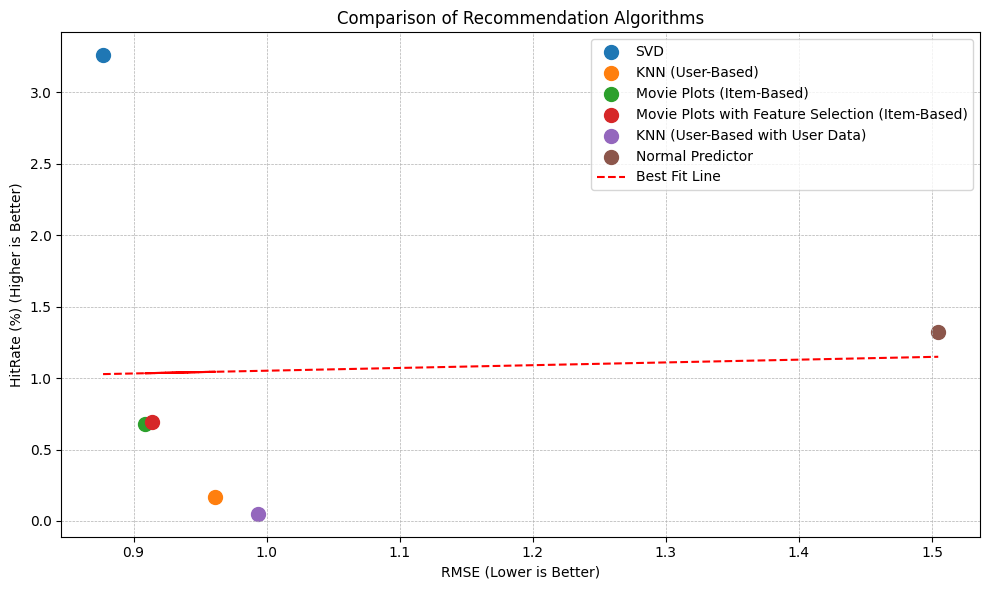

In [ ]:
# Remove the duplicate "Normal Predictor" entry
algorithms = ["SVD", "KNN (User-Based)", "Movie Plots (Item-Based)", "Movie Plots with Feature Selection (Item-Based)", "KNN (User-Based with User Data)", "Normal Predictor"]
rmse_values = [0.8771, 0.9614, 0.9087, 0.9136, 0.9939, 1.5047]
hitrate_values = [3.26, 0.17, 0.68, 0.69, 0.05, 1.32]

# Create scatter plot without different shapes
plt.figure(figsize=(10, 6))
for i, algo in enumerate(algorithms):
    plt.scatter(rmse_values[i], hitrate_values[i], label=algo, s=100)

# Best fit curve
plt.plot(rmse_values, p(rmse_values), "r--", label="Best Fit Line")

plt.title("Comparison of Recommendation Algorithms")
plt.xlabel("RMSE (Lower is Better)")
plt.ylabel("HitRate (%) (Higher is Better)")
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()